
# PHYS20762 - Project - Measuring Drop Spreading Law

University of Manchester  
January 2021

In this cell below, the requierd libraries are imported, and plotting parameters are set.

In [13]:
# =============================================================================
# Initialization and Imports
# =============================================================================
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

# Set global plot parameters (font size and style)
plt.rcParams.update({'font.size': 14})
plt.style.use('default')


## Experimental Data

This is data consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

in this cell below, the radius from three separate experiments, and their corresponding time points are defined.

In [14]:
# =============================================================================
# Experimental Data: Radius Measurements and Time Points
# =============================================================================
# Radius data (in μm) from three experimental runs
radius_exp1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
radius_exp2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
radius_exp3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# Time data (in seconds)
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])


In this one, a plot is produced to visualize the raw experimental data.

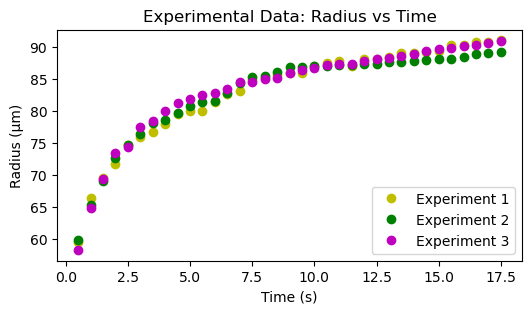

In [3]:
## =============================================================================
# Plotting Raw Experimental Data
# =============================================================================
plt.rcParams["figure.figsize"] = (6, 3)  # Set figure size for clarity
plt.figure()
# Plot each experimental run with distinct colors and markers
plt.plot(time, radius_exp1, "yo", label="Experiment 1")
plt.plot(time, radius_exp2, "go", label="Experiment 2")
plt.plot(time, radius_exp3, "mo", label="Experiment 3")
plt.xlabel("Time (s)")
plt.ylabel("Radius (μm)")
plt.title("Experimental Data: Radius vs Time")
plt.legend()
plt.show()


This cell below combined the three experimental radius arrays, and then computes the mean and standard deviation at each time point. Also, an error bar plot is generated.

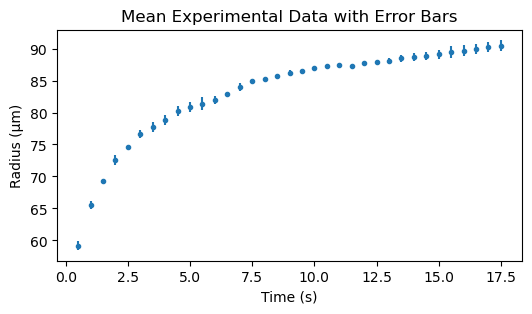

In [4]:
# =============================================================================
# Calculate Mean and Standard Deviation of Radius Data
# =============================================================================
# Combine the radius data from all experiments into a single array
radius_experiments = np.array([radius_exp1, radius_exp2, radius_exp3])
# Compute the mean radius at each time point
mean_radius = np.mean(radius_experiments, axis=0)
# Compute the standard deviation at each time point
std_radius = np.std(radius_experiments, axis=0)

# Plot the mean radius with error bars (standard deviation)
plt.errorbar(time, mean_radius, yerr=std_radius, fmt='.')
plt.xlabel("Time (s)")
plt.ylabel("Radius (μm)")
plt.title("Mean Experimental Data with Error Bars")
plt.show()



## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

In this cell three main codes are written. Firstly, the droplet's height was measured using the radius and volume given.

In [5]:
# =============================================================================
# Constants
# =============================================================================
V_pL = 7.6  # Volume in picoliters
V = V_pL * 1e3  # Convert volume to μm³ (1 pL = 1e3 μm³)

# =============================================================================
# Function Definitions
# =============================================================================
def compute_height(R):
    """
    Compute the height (H) from the radius (R) using a cubic equation based on volume conservation.
    Equation: H^3 + 3R^2 * H - (6V)/π = 0
    """
    if R <= 0:
        return 0  # Ensure a non-negative height
    
    # Define the cubic equation in H
    cubic_equation = lambda H: H**3 + 3 * R**2 * H - (6 * V) / np.pi
    # Provide a positive initial guess for H
    initial_guess = max((2 * V / (np.pi * 3 * R**2))**(1/3), 1e-6)
    H_solution = fsolve(cubic_equation, initial_guess)
    
    # Return the computed height, ensuring it is positive
    return max(H_solution[0], 1e-6)

def compute_contact_angle(R, H):
    """
    Compute the contact angle (θ) using droplet geometry.
    Formula: θ = (π/2) - arctan((R² - H²) / (2RH))
    """
    return (np.pi / 2) - np.arctan((R**2 - H**2) / (2 * R * H))

# =============================================================================
# Compute Heights and Contact Angles from Mean Radius
# =============================================================================
# Calculate the droplet height for each mean radius value
heights = np.array([compute_height(R) for R in mean_radius])
# Calculate the contact angle for each data point using the computed heights
theta_values = (np.pi / 2) - np.arctan((mean_radius**2 - heights**2) / (2 * mean_radius * heights))

# =============================================================================
# Error Propagation for Height and Contact Angle
# =============================================================================
H_errors = []     # To store errors in height (H)
theta_errors = [] # To store errors in contact angle (θ)

# Loop over each measurement to estimate uncertainty via perturbation
for i in range(len(mean_radius)):
    R = mean_radius[i]
    sigma_R = std_radius[i]
    
    # Compute heights for R perturbed by ±σ_R (ensuring R remains positive)
    H_plus = compute_height(R + sigma_R)
    H_minus = compute_height(max(R - sigma_R, 1e-6))
    
    # Compute the corresponding contact angles for the perturbed values
    theta_plus = compute_contact_angle(R + sigma_R, H_plus)
    theta_minus = compute_contact_angle(R - sigma_R, H_minus)
    
    # Estimate the error as half the difference between the perturbed values
    H_errors.append(abs((H_plus - H_minus) / 2))
    theta_errors.append(abs((theta_plus - theta_minus) / 2))

# Convert error lists to numpy arrays for further calculations
H_errors = np.array(H_errors)
theta_errors = np.array(theta_errors)

# =============================================================================
# Compute Spreading Speed (U) from Radius Data
# =============================================================================
# Calculate the time derivative (gradient) of the radius for each experimental run
speed_exp1 = np.gradient(radius_exp1, time)
speed_exp2 = np.gradient(radius_exp2, time)
speed_exp3 = np.gradient(radius_exp3, time)

# Compute the mean spreading speed and its standard deviation across experiments
mean_U = np.mean([speed_exp1, speed_exp2, speed_exp3], axis=0)
std_U = np.std([speed_exp1, speed_exp2, speed_exp3], axis=0, ddof=1)

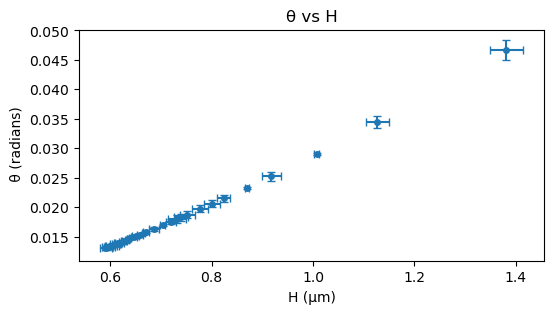

In [6]:
# =============================================================================
# Plot θ vs H with error bars
# =============================================================================
plt.errorbar(heights, theta_values, xerr=H_errors, yerr=theta_errors, fmt='o', markersize=4, capsize=3)
plt.ylabel(' θ (radians)')
plt.xlabel('H (μm)')
plt.title('θ vs H')
plt.show()


The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

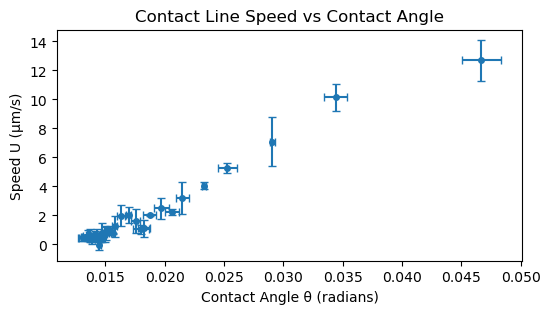

In [7]:
# =============================================================================
# Plot U vs θ with error bars
# =============================================================================
plt.errorbar(theta_values, mean_U, xerr=theta_errors, yerr=std_U, fmt='o', markersize=4, capsize=3)
plt.xlabel('Contact Angle θ (radians)')
plt.ylabel('Speed U (μm/s)')
plt.title('Contact Line Speed vs Contact Angle')
plt.show()


## Fitting Spreading Laws

I will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, a straight line will be fitted to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [8]:
# =============================================================================
# Linearized Fit for the Cox–Voinov Model
# =============================================================================
# Original model: U = U0*(θ³ - θ0³)
# Linearized form: U = U0*θ³ + c, where c = -U0*θ0³

# Prepare the independent variable by raising theta to the third power
theta_cubed = theta_values**3

# Perform weighted linear regression using np.polyfit:
coeffs_cox, cov_cox = np.polyfit(theta_cubed, mean_U, 1, w=1.0/std_U, cov=True)

# Unpack the fitted slope and intercept from the regression
slope_cox, intercept_cox = coeffs_cox
U0_cox_lin = slope_cox  # In the linearized form, the slope equals U0

# Calculate θ0 from the intercept:
#   - Rearranged from intercept = -U0 * θ0³ => θ0³ = -intercept / U0
#   - Ensure the computed value is positive and valid.
if slope_cox != 0 and (-intercept_cox/slope_cox) > 0:
    theta0_cox_lin = (-intercept_cox / slope_cox)**(1/3)
else:
    theta0_cox_lin = np.nan  # Return NaN if the solution is invalid

# Compute the uncertainty in U0 from the covariance matrix
err_U0_cox = np.sqrt(cov_cox[0, 0])

# Error propagation for θ0 using partial derivatives:
# Define an auxiliary variable A = -intercept/slope (which equals θ0³)
A_cox = -intercept_cox / slope_cox  
# Compute the partial derivative of θ0 with respect to the intercept
dtheta0_dIntercept = - (1/(3 * slope_cox)) * A_cox**(-2/3)
# Compute the partial derivative of θ0 with respect to the slope
dtheta0_dSlope = (1/3) * A_cox**(-2/3) * (intercept_cox/(slope_cox**2))
# Combine the uncertainties from the intercept and slope using error propagation formula
var_theta0_cox = (dtheta0_dIntercept**2 * cov_cox[1, 1] +
                  dtheta0_dSlope**2 * cov_cox[0, 0] +
                  2 * dtheta0_dIntercept * dtheta0_dSlope * cov_cox[0, 1])
err_theta0_cox = np.sqrt(var_theta0_cox)


# =============================================================================
# Linearized Fit for the de Gennes Model
# =============================================================================
# Original model: U = U0*(θ² - θ0²)
# Linearized form: U = U0*θ² + c, where c = -U0*θ0²

# Prepare the independent variable by squaring theta
theta_squared = theta_values**2

# Perform weighted linear regression for the de Gennes model:
coeffs_deG, cov_deG = np.polyfit(theta_squared, mean_U, 1, w=1.0/std_U, cov=True)

# Unpack the slope and intercept for the de Gennes fit
slope_deG, intercept_deG = coeffs_deG
U0_deG_lin = slope_deG  # Slope is U0 for the de Gennes model

# Calculate θ0 from the intercept:
#   - From intercept = -U0 * θ0² => θ0² = -intercept / U0
if slope_deG != 0 and (-intercept_deG/slope_deG) > 0:
    theta0_deG_lin = np.sqrt(-intercept_deG / slope_deG)
else:
    theta0_deG_lin = np.nan  # Return NaN if the solution is invalid

# Compute the uncertainty in U0 for the de Gennes model from its covariance matrix
err_U0_deG = np.sqrt(cov_deG[0, 0])

# Error propagation for θ0 in the de Gennes model:
# Define auxiliary variable A = -intercept/slope (which equals θ0²)
A_deG = -intercept_deG / slope_deG  
# Compute the partial derivative of θ0 with respect to the intercept
dtheta0_dIntercept_deG = -1/(2 * slope_deG) * A_deG**(-1/2)
# Compute the partial derivative of θ0 with respect to the slope
dtheta0_dSlope_deG = (1/2) * A_deG**(-1/2) * (intercept_deG/(slope_deG**2))
# Combine uncertainties using error propagation
var_theta0_deG = (dtheta0_dIntercept_deG**2 * cov_deG[1, 1] +
                  dtheta0_dSlope_deG**2 * cov_deG[0, 0] +
                  2 * dtheta0_dIntercept_deG * dtheta0_dSlope_deG * cov_deG[0, 1])
err_theta0_deG = np.sqrt(var_theta0_deG)


# =============================================================================
# Compute Model Predictions and Residuals
# =============================================================================
# Generate a smooth range of theta values for plotting the fitted curves
theta_fit = np.linspace(min(theta_values), max(theta_values), 200)

# Compute the predicted speeds for the Cox–Voinov model using the fitted parameters:
#   U = U0*(θ³ - θ0³)
U_pred_cox = U0_cox_lin * (theta_values**3 - theta0_cox_lin**3)
# Compute the predicted speeds for the de Gennes model:
#   U = U0*(θ² - θ0²)
U_pred_deG = U0_deG_lin * (theta_values**2 - theta0_deG_lin**2)

# Calculate the residuals for each model (difference between experimental and predicted U)
resid_cox = mean_U - U_pred_cox
resid_deG = mean_U - U_pred_deG

# Compute smooth fitted curves for plotting using the smooth theta_fit array
U_fit_cox_lin = U0_cox_lin * (theta_fit**3 - theta0_cox_lin**3)
U_fit_deG_lin = U0_deG_lin * (theta_fit**2 - theta0_deG_lin**2)


## Chi-squared Test

To establish which of the two laws better fits the data, the chi-squared test will be conduct. The case is further strengthened using the residual plots. 

In [15]:
# =============================================================================
# Chi-Squared Calculations for Model Fits
# =============================================================================
# Calculate chi-squared and reduced chi-squared for the Cox–Voinov model
chi2_cox = np.sum(((mean_U - U_pred_cox) / std_U)**2)
dof_cox = len(mean_U) - 2  # Degrees of freedom (2 fitted parameters)
chi2_red_cox = chi2_cox / dof_cox

# Calculate chi-squared and reduced chi-squared for the de Gennes model
chi2_deG = np.sum(((mean_U - U_pred_deG) / std_U)**2)
dof_deG = len(mean_U) - 2
chi2_red_deG = chi2_deG / dof_deG

Displaying the corresponding fits  

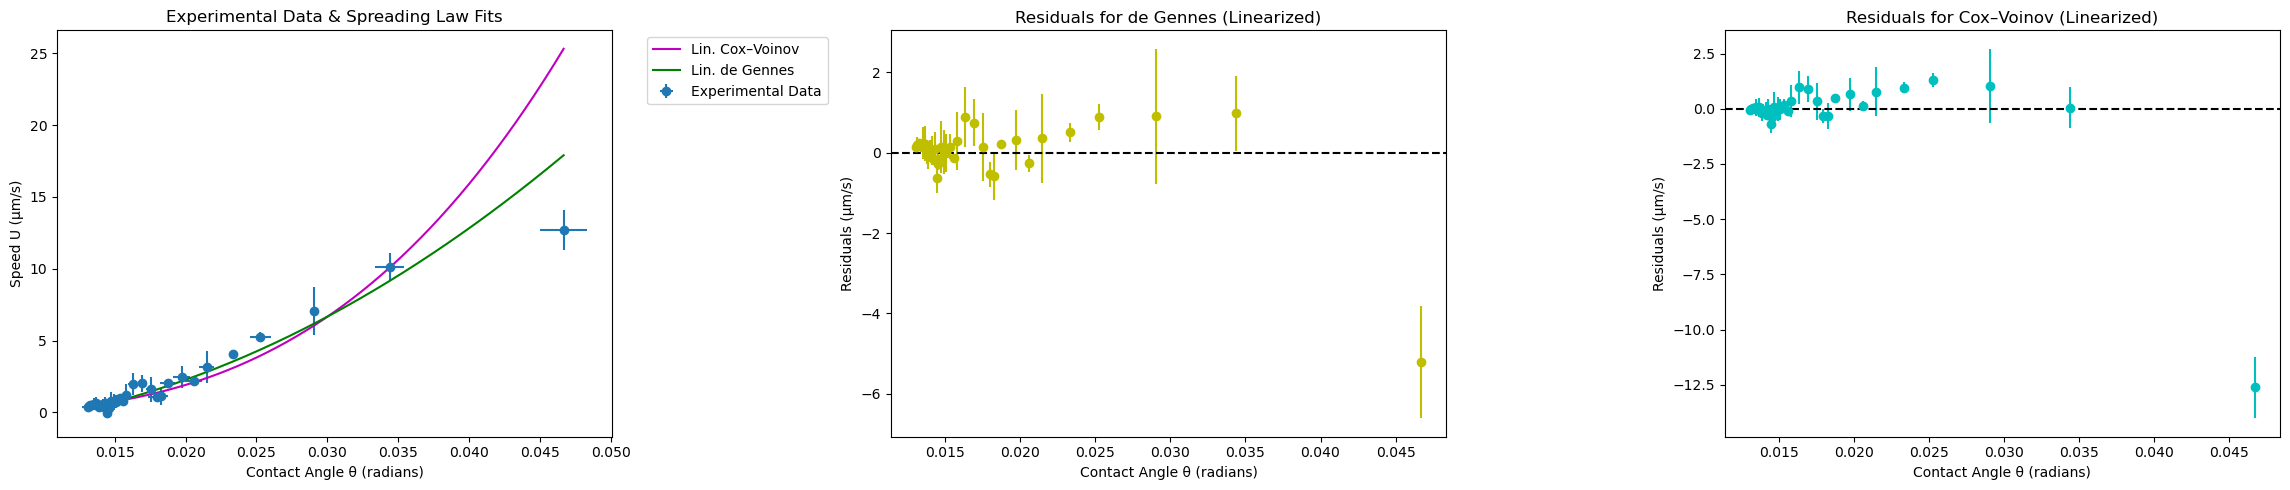

In [10]:
# =============================================================================
# Plotting Data, Fits, and Residuals
# =============================================================================
# Set the overall figure size for the plot layout
plt.rcParams["figure.figsize"] = (23, 5)

# Create a figure with 3 subplots arranged in one row:
# - ax1 for experimental data with the fitted curves
# - ax2 for residuals from the de Gennes model fit
# - ax3 for residuals from the Cox–Voinov model fit
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False)

# (1) Plot Experimental Data with Linearized Fits
# Plot experimental data points with error bars for both contact angle (θ) and speed U
ax1.errorbar(theta_values, mean_U, xerr=theta_errors, yerr=std_U,
             fmt='o', label='Experimental Data')
# Plot the fitted curve for the Cox–Voinov model (using the smooth theta_fit values)
ax1.plot(theta_fit, U_fit_cox_lin, 'm-', label='Lin. Cox–Voinov')
# Plot the fitted curve for the de Gennes model
ax1.plot(theta_fit, U_fit_deG_lin, 'g-', label='Lin. de Gennes')
ax1.set_xlabel('Contact Angle θ (radians)')
ax1.set_ylabel('Speed U (μm/s)')
ax1.set_title('Experimental Data & Spreading Law Fits')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# (2) Plot Residuals for de Gennes Fit
# Plot the residuals (difference between experimental U and the de Gennes model prediction)
ax2.errorbar(theta_values, resid_deG, yerr=std_U, fmt='oy')
# Draw a horizontal dashed line at zero to help assess the quality of the fit
ax2.axhline(0, color='k', linestyle='--')
ax2.set_xlabel('Contact Angle θ (radians)')
ax2.set_ylabel('Residuals (μm/s)')
ax2.set_title('Residuals for de Gennes (Linearized)')

# (3) Plot Residuals for Cox–Voinov Fit
# Plot the residuals for the Cox–Voinov model fit with error bars
ax3.errorbar(theta_values, resid_cox, yerr=std_U, fmt='oc')
# Add a horizontal dashed line at zero for reference
ax3.axhline(0, color='k', linestyle='--')
ax3.set_xlabel('Contact Angle θ (radians)')
ax3.set_ylabel('Residuals (μm/s)')
ax3.set_title('Residuals for Cox–Voinov (Linearized)')

# Adjust subplot layout to prevent overlapping elements
plt.tight_layout()
plt.show()


## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the "de Gennes" law is a better fit for the behaviour of the spreading drop because ...  

In [11]:
# =============================================================================
# Print the Fit Results with Chi-Squared Information
# =============================================================================
print("Linearized Fit Results:")
print("Cox–Voinov:")
print(f"  U0 = {U0_cox_lin:.2e} μm/s ± {err_U0_cox:.2e} μm/s")
print(f"  theta0 = {theta0_cox_lin:.4f} ± {err_theta0_cox:.4f} radians")
print(f"  chi^2 = {chi2_cox:.2f}, Reduced chi^2 = {chi2_red_cox:.2f}")
print()
print("de Gennes:")
print(f"  U0 = {U0_deG_lin:.2e} μm/s ± {err_U0_deG:.2e} μm/s")
print(f"  theta0 = {theta0_deG_lin:.4f} ± {err_theta0_deG:.4f} radians")
print(f"  chi^2 = {chi2_deG:.2f}, Reduced chi^2 = {chi2_red_deG:.2f}")

Linearized Fit Results:
Cox–Voinov:
  U0 = 2.50e+05 μm/s ± 2.15e+04 μm/s
  theta0 = 0.0069 ± 0.0027 radians
  chi^2 = 195.49, Reduced chi^2 = 5.92

de Gennes:
  U0 = 8.78e+03 μm/s ± 4.81e+02 μm/s
  theta0 = 0.0119 ± 0.0003 radians
  chi^2 = 89.44, Reduced chi^2 = 2.71


To conclude, after analyzing the given data, the results suggest that de Gennes’ law aligns more closely with the experiment. The reduced chi-squared value for de Gennes is 2.71, while Cox-Voinov has a value of 5.92. This result demonstrates the consistency of de Gennes’ law.

Furthermore, in terms of the order of magnitude for the speed, it is reasonable since the radius has an order of magnitude of μm. Additionally, regarding the errors, the fact that both de Gennes and Cox-Voinov laws yield reduced chi-squared values close to one suggests that the uncertainty is reasonable and consistent. Moreover, the scale of the uncertainty is reasonable, as the radii are measured in μm.

Lastly, the results also implies that the regime in which this experiment operates corresponds to very small contact angles.


## Extra Work


In the code above, I used PolyFit by linearizing the laws, a method suggested to me by one of the demonstrators. They mentioned that this approach would be more suitable for me to understand, as it will be used in the upcoming weeks’ materials.

After that, I decided to determine the values of the reduced chi-squared if I used a nonlinear function to find the best fit for the two laws. Below, CurveFit is used to determine the best fits. This function is highly sensitive to the initial values provided for the fitting process. Therefore, by using the available data on the speed of the contact angle, I supplied initial values that were close to the expected fit.

The results are shown below:


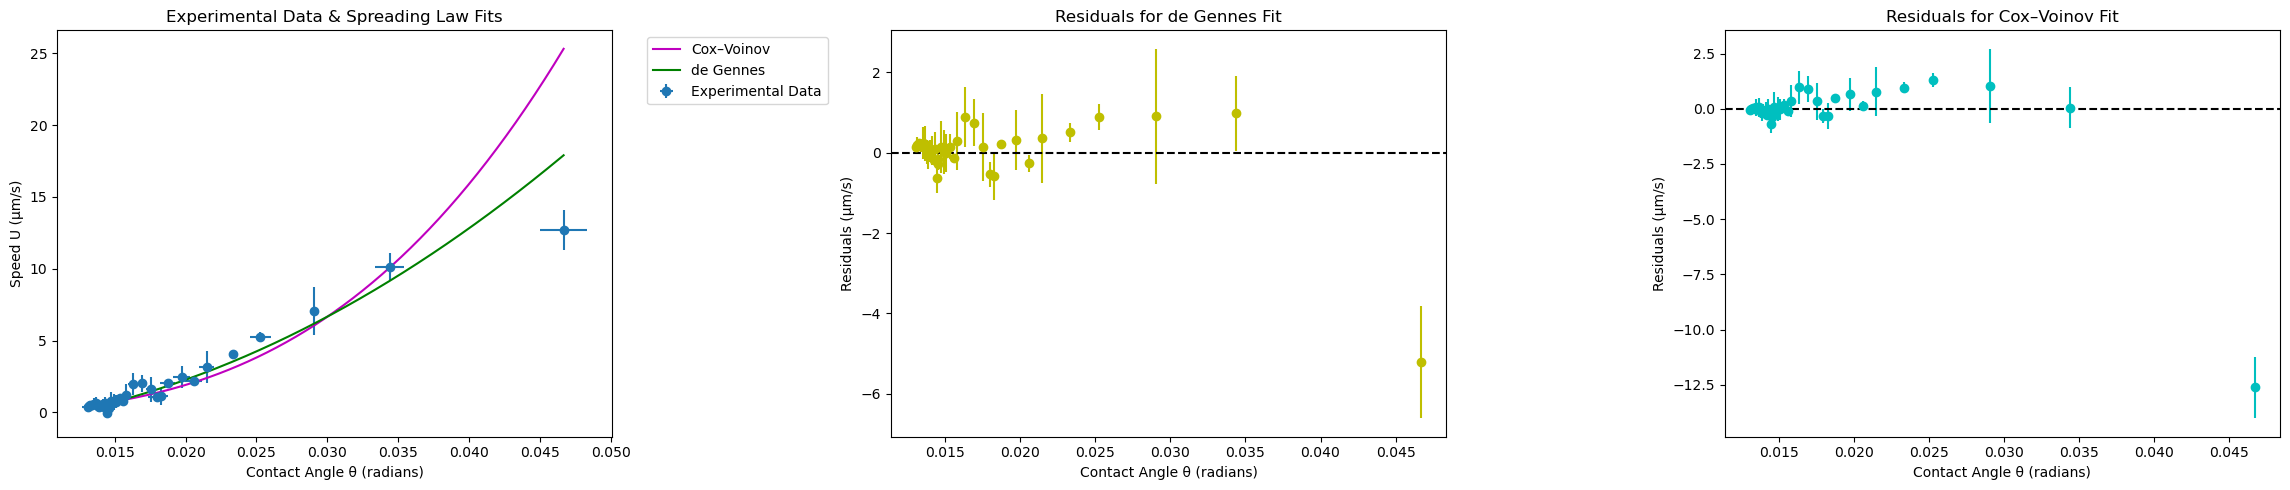

curve_fit Results:
Cox–Voinov: U0 = 2.50e+05 μm/s ± 2.2e+04 μm/s, θ0 = 0.0069 rad ± 0.0027 rad
  Chi-squared: 195.49, Reduced Chi-squared: 5.92

de Gennes:  U0 = 8.78e+03 μm/s ± 4.8e+02 μm/s, θ0 = 0.0119 rad ± 0.0003 rad
  Chi-squared: 89.44, Reduced Chi-squared: 2.71


In [12]:
from scipy.optimize import curve_fit

# --- Define the model functions ---
def cox_vinov(theta, U0, theta0):
    # Cox–Voinov model: Spreading speed U = U0 * (theta^3 - theta0^3)
    return U0*(theta**3 - theta0**3)

def de_gennes(theta, U0, theta0):
    # de Gennes model: Spreading speed U = U0 * (theta^2 - theta0^2)
    return U0*(theta**2 - theta0**2)

# --- Perform fits using curve_fit ---
# Use curve_fit to optimize the model parameters for each model.
# 'mean_U' are the experimental speeds, 'p0' gives initial guesses,
# and 'sigma=std_U' provides weighting based on measurement uncertainties.
popt_cu, pcov_cu = curve_fit(cox_vinov, theta_values, mean_U, p0=[1, 0.01], sigma=std_U)
popt_sq, pcov_sq = curve_fit(de_gennes, theta_values, mean_U, p0=[1, 0.01], sigma=std_U)

# --- Extract parameters and their errors ---
# The optimal parameters (U0 and theta0) are stored in popt_*.
U0_cu, theta0_cu = popt_cu
U0_sq, theta0_sq = popt_sq

# The square roots of the diagonal elements of the covariance matrices give the uncertainties.
err_cu = np.sqrt(np.diag(pcov_cu))
err_sq = np.sqrt(np.diag(pcov_sq))

# --- Calculate fitted values and residuals ---
# Calculate the model predictions for the experimental theta_values using the fitted parameters.
U_fitted_cu = cox_vinov(theta_values, *popt_cu)
U_fitted_de = de_gennes(theta_values, *popt_sq)

# Compute residuals: the differences between experimental mean_U and the fitted model values.
residuals_cu = mean_U - U_fitted_cu
residuals_de = mean_U - U_fitted_de

# --- Compute chi-squared values ---
chi2_cu = np.sum(((mean_U - cox_vinov(theta_values, *popt_cu))/std_U)**2)
dof_cu = len(mean_U) - len(popt_cu)  # Degrees of freedom: number of data points minus the number of fitted parameters.
chi2_red_cu = chi2_cu / dof_cu     # Reduced chi-squared.

chi2_sq = np.sum(((mean_U - de_gennes(theta_values, *popt_sq))/std_U)**2)
dof_sq = len(mean_U) - len(popt_sq)
chi2_red_sq = chi2_sq / dof_sq

# --- Create a figure with three subplots ---
plt.rcParams["figure.figsize"] = (23, 5)  # Set the overall figure size.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False)  # Create a figure with three subplots.

# (1) Plot Experimental Data with Both Fits
# Plot experimental data with error bars for both x (theta) and y (U) values.
ax1.errorbar(theta_values, mean_U, xerr=theta_errors, yerr=std_U, fmt='o', label='Experimental Data')
# Plot the fitted curve from the Cox–Voinov model using a smooth set of theta values (theta_fit).
ax1.plot(theta_fit, cox_vinov(theta_fit, *popt_cu), 'm-', label='Cox–Voinov')
# Plot the fitted curve from the de Gennes model.
ax1.plot(theta_fit, de_gennes(theta_fit, *popt_sq), 'g-', label='de Gennes')
ax1.set_xlabel('Contact Angle θ (radians)')
ax1.set_ylabel('Speed U (μm/s)')
ax1.set_title('Experimental Data & Spreading Law Fits')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# (2) Plot Residuals for de Gennes Fit
# Plot the residuals for the de Gennes model fit with error bars.
ax2.errorbar(theta_values, residuals_de, yerr=std_U, fmt='oy')
ax2.axhline(0, color='k', linestyle='--')  # Add a horizontal line at zero for reference.
ax2.set_xlabel('Contact Angle θ (radians)')
ax2.set_ylabel('Residuals (μm/s)')
ax2.set_title('Residuals for de Gennes Fit')

# (3) Plot Residuals for Cox–Voinov Fit
# Plot the residuals for the Cox–Voinov model fit with error bars.
ax3.errorbar(theta_values, residuals_cu, yerr=std_U, fmt='oc')
ax3.axhline(0, color='k', linestyle='--')  # Add a horizontal line at zero for reference.
ax3.set_xlabel('Contact Angle θ (radians)')
ax3.set_ylabel('Residuals (μm/s)')
ax3.set_title('Residuals for Cox–Voinov Fit')

plt.tight_layout()  # Adjust the subplots to fit within the figure area.
plt.show()  # Display the plots.

# --- Print the fit results and chi-squared values ---
# Output the optimized fit parameters and their uncertainties, along with the chi-squared values.
print("curve_fit Results:")
print(f"Cox–Voinov: U0 = {U0_cu:.2e} μm/s ± {err_cu[0]:.1e} μm/s, θ0 = {theta0_cu:.4f} rad ± {err_cu[1]:.4f} rad")
print(f"  Chi-squared: {chi2_cu:.2f}, Reduced Chi-squared: {chi2_red_cu:.2f}")
print()
print(f"de Gennes:  U0 = {U0_sq:.2e} μm/s ± {err_sq[0]:.1e} μm/s, θ0 = {theta0_sq:.4f} rad ± {err_sq[1]:.4f} rad")
print(f"  Chi-squared: {chi2_sq:.2f}, Reduced Chi-squared: {chi2_red_sq:.2f}")

The results here show that when accurate initial values are chosen, CurveFit and PolyFit can produce similar results. Additionally, these results indicate that PolyFit is more convenient to use, as it does not require initial guesses.
